In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from dataset import CrowdCountingDataset
from matplotlib import cm as CM
import matplotlib.pyplot as plt
from model import MCNN

In [22]:
model = MCNN()

In [29]:
checkpoint = torch.load('checkpoints/MCNN_shanghaitechA_normal_1000epoch_1e-05lr_1bs.pth')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [30]:
model.eval()

MCNN(
  (branch1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): ReLU(inplace=True)
    (8): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (9): ReLU(inplace=True)
  )
  (branch2): Sequential(
    (0): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(      
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)])

In [326]:
train_data = CrowdCountingDataset('../../shanghaitech/part_A_test.json', transform=transform)
dataloader = DataLoader(train_data, batch_size=1, shuffle=True)

In [345]:
data_iter = iter(dataloader)
imgs, densitys = data_iter.__next__()


预测人数: 1019.03271484375
真实人数: 931.7591552734375


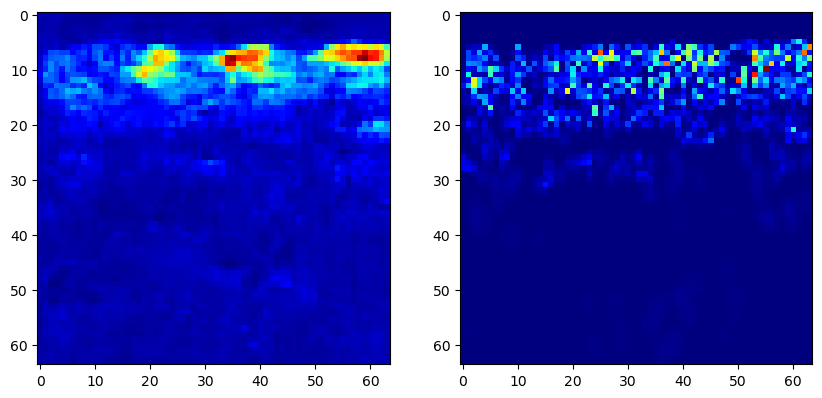

: 

In [346]:
with torch.no_grad():
    output = model(imgs)
    output1 = output[0]
    print(f'预测人数: {torch.sum(output1[0])}')
    print(f'真实人数: {torch.sum(densitys[0])}')
    # output1 = np.squeeze(output1)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(output1[0].numpy(), cmap=CM.jet)

    ax[1].imshow(densitys[0].numpy(), cmap=CM.jet)

    plt.show()

In [7]:
from PIL import Image

In [26]:
img = Image.open("./image2.png").convert("RGB")

img_tensor = transform(img).unsqueeze(0)

print(img_tensor.shape)

torch.Size([1, 3, 256, 256])


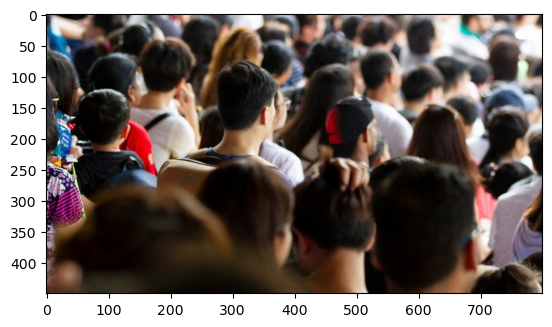

In [27]:
plt.imshow(img)

预测人数: 56.257423400878906


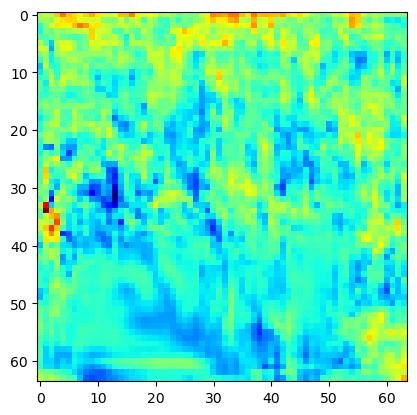

In [31]:
with torch.no_grad():
    output = model(img_tensor)
    print(f'预测人数: {torch.sum(output[0])}')
    density_map = output.squeeze().numpy()
    plt.imshow(density_map, cmap='jet')